# Viz Seattle Bicycle Counts

This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.

In [12]:
import pandas as pd
import numpy as np

data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


For convenience, we'll further process this dataset by shortening the column names and adding a "Total" column:

In [13]:
print(data.columns)
data.columns = ['East', 'West']
data['Total'] = data.eval('East + West')

# Summary Stats
data.dropna().describe()

Index(['Fremont Bridge East Sidewalk', 'Fremont Bridge West Sidewalk'], dtype='object')


,East,West,Total
count,50319.000000,50319.000000,50319.000000
mean,56.934399,52.940678,109.875077
std,82.835585,68.728939,138.526584
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,28.000000,29.000000,60.000000
75%,69.000000,70.000000,143.000000
max,717.000000,698.000000,957.000000


## Visualizing the data

Let's plot the raw data:

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

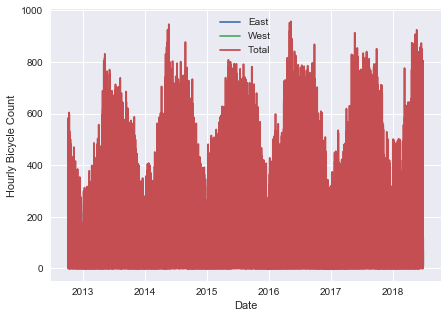

In [25]:
data.plot(figsize=(7, 5))
plt.ylabel('Hourly Bicycle Count');

The hourly samples are fare too dense for us to make much sense of. We can gain more insight by resampling the data to a coarser grid. Let's resample by week:

Text(0,0.5,'Weekly bicycle count')

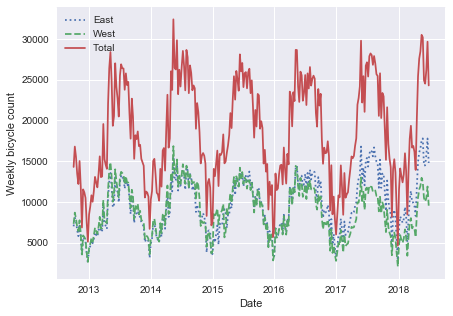

In [24]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'], figsize=(7, 5))
plt.ylabel('Weekly bicycle count')

This shows us some interesting seasonal trends: People bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather);

Another way that comes in handy for aggregating the data is to use a rolling mean, utilizing the `pd.rolling_mean()` function. Here we'll do a 30 day rolling mean of our data, making sure to center the window.

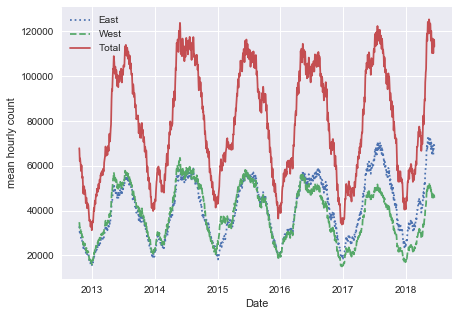

In [33]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'], figsize=(7, 5))
plt.ylabel('mean hourly count');

The roughness of the result is due to the hard cutoff of the windwos. We can get a smoother version of a rolling mean using a window function-for example, a Gaussian window. The following code specifies both the width of the window (we chose 50 days) and the width of the Gaussian within the window (we chose 10 days):

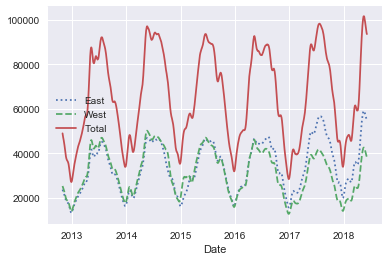

In [34]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

## Digging into the data

Let's look at the avergae traffic as a function of time of day. we can do this using the GroupBy function.

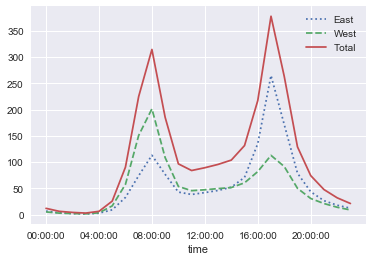

In [41]:
by_time = data.groupby(data.index.time).mean()
# Every 4 hours
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'])

The hourly traffic is a strongly bimodal distribution, with peaks around 8:00 in the morning and 5:00 in the evening. This is likely evidence of a strong component of commuter traffic crossing the bridge. This is further evidenced by the differences between the western sidewalk (generally used going toward downtown Seattle), which peaks more strongly in the morning, and the eastern sidewalk (generally used going away from downtown Seattle), which peaks more strongly in the evening.

Now let's see how things change based on the week. Again we can do this with a simple groupby:

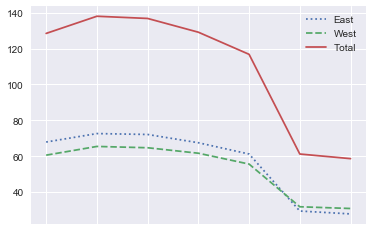

In [48]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

Let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends. We'll start by grouping by both a flag marking the weekend, and the time of day:

In [54]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

C:\Users\Batakrishna\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


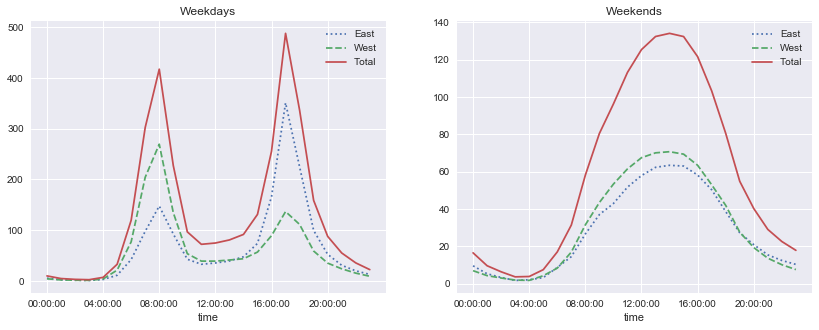

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

The result is very interesting: we see a bimodal commute pattern during the work week, and a unimodal recreational pattern during the weekends.